# Homework 3 (100 points)

The goal of this homework is to practice techniques relating to SVD.

## Exercise 1 (65 points)

a) Fetch the "mnist_784" data and store is as a `.csv` (that way you don't have to fetch it every time - which takes about 30s). (4 points)

In [358]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from numpy import genfromtxt

from sklearn.datasets import fetch_openml

X, y = fetch_openml(name="mnist_784", version=1, return_X_y=True, as_frame=False)


# if not downloaded :
# pd.DataFrame(X).to_csv("X_mnist.csv", index=False)
# pd.DataFrame(y).to_csv("y_mnist.csv", index=False)

# since it's already downloaded, read it in 
X = genfromtxt('X_mnist.csv', delimiter=',')
y = genfromtxt('y_mnist.csv', delimiter=',')
X=X[1:]
y=y[1:]

X_df = pd.read_csv('X_mnist.csv')

b) Plot the singular value plot for a single example of the 0 digit (5 points)

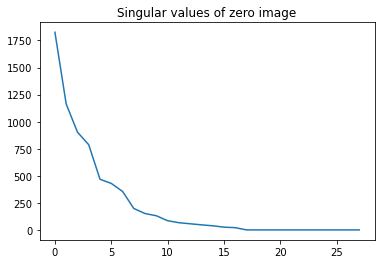

In [359]:
# to get an example of the 0 digit, check in labels present in y  
index, = np.where(y == 0) # gets the indices where there are all zeros 
img = X[index[0]].reshape(28,28)

img_init = img.copy()
u,s,vt=np.linalg.svd(img_init,full_matrices=False)
_ = plt.plot(s)
plt.title('Singular values of zero image')
plt.show()

c) By setting some singular values to 0, plot the approximation of the 0 digit next to the original digit. (5 points)

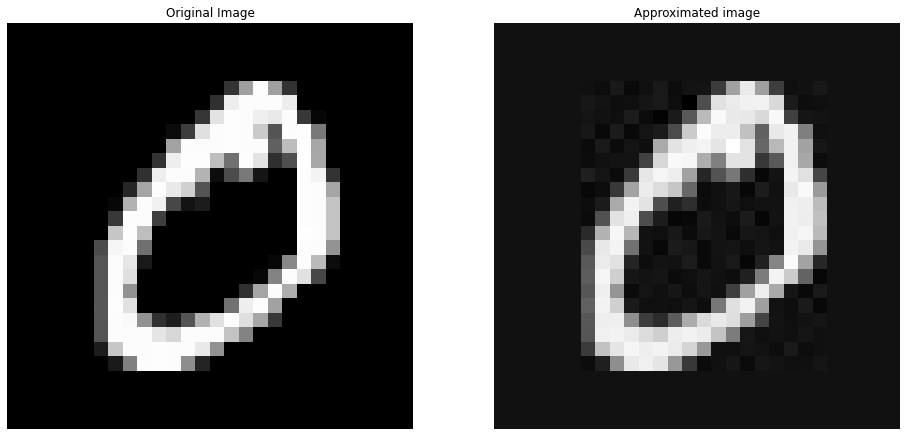

In [267]:
# Based on b, let us take all values from 16 to 28 as zero in the singular matrix s.

s_copy = s.copy()
s_copy[10:]=0

# constructing matrix after setting some singular values to zero 
img_reconstruct = u@np.diag(s_copy)@vt
plt.figure(figsize = (16, 8))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap = 'gray')
plt.axis('off')
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(img_reconstruct, cmap = 'gray')
plt.axis('off')
plt.title("Approximated image");


d) Consider the entire dataset as a matrix. Perform SVD and store the dataset approximation in a new `.csv` file. Explain why / how you chose a particular rank. (10 points)

In [122]:
approx = pd.DataFrame(columns=X_df.columns)
for ind in range(len(X)):
    img = X[ind].reshape(28,28)
    u,s,vt=np.linalg.svd(img,full_matrices=False)
    s_copy = s.copy() 
    s_copy[10:]=0
    img_reconstruct = u@np.diag(s_copy)@vt
    img_reconstruct = img_reconstruct.reshape(784,)
    approx.loc[ind] = img_reconstruct.tolist()
    
approx.to_csv('dataset_approx.csv', index=False)

In [268]:
# if loading in the approximated dataset of X
approx_loaded = pd.read_csv('dataset_approx.csv')
approx_loaded.shape

(70000, 784)

0 is the least sparse digit, and rank 10 worked for it. Other digits are similarly or lesser sparsed than zero. By looking at the singular plot for the 0 digit, we can see a sharp decline occurs around rank=10 n the X-axis. Based off on this threshold that we have set, we choose rank 10 for our analysis.

e) As in homework 2, using Kmeans on this new dataset, cluster the images from d) using 10 clusters and plot the centroid of each cluster. (10 points)

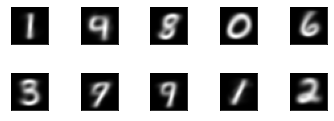

In [269]:
from IPython.core.pylabtools import figsize
from sklearn.cluster import KMeans

origlabel = y

data = approx_loaded.copy()
kmeans = KMeans(n_clusters=10, random_state=0).fit(data)
approx_label = kmeans.labels_

np.savetxt('origlabel',origlabel)
np.savetxt('approx_label',approx_label)


centroid = kmeans.cluster_centers_

rows = 2
cols = 5
axes=[]
fig=plt.figure(figsize = (cols,rows))

for i in range(rows*cols):
    ax = fig.add_subplot(rows, cols, i+1)
    axes.append(ax)
    plt.imshow(centroid[i,:].reshape(28,28),cmap='gray')
fig.tight_layout()    
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.show()

f) Repeat e) on the original dataset. Comment on any differences (or lack thereof) you observe. (8 points)

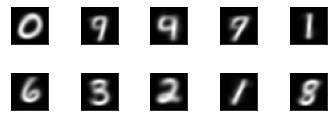

In [270]:
from IPython.core.pylabtools import figsize
from sklearn.cluster import KMeans

origlabel = y

data = X.copy()
kmeans = KMeans(n_clusters=10, random_state=1).fit(data)
X_label = kmeans.labels_

np.savetxt('origlabel',origlabel)
np.savetxt('X_label',X_label)


centroid = kmeans.cluster_centers_

rows = 2
cols = 5
axes=[]
fig=plt.figure(figsize = (cols,rows))

for i in range(rows*cols):
    ax = fig.add_subplot(rows, cols, i+1)
    axes.append(ax)
    plt.imshow(centroid[i,:].reshape(28,28),cmap='gray')
fig.tight_layout()    
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.show()

g) Compare the disagreement distance of the clustering obtained in e) to the true labels, to the disagreement distance of the clustering obtained in f) to the true labels. Comment briefly. (8 points)

In [281]:
def disagreement_dist(P_labels, C_labels):
    
    df = pd.DataFrame(columns = ['C', 'P'])
    df['P'] = pd.Series(P_labels)
    df['C'] = pd.Series(C_labels)
    

    result = pd.merge(left = df, right=df, on='C', how="outer", sort=False)
    filt = result[result["P_x"]!=result["P_y"]]

    a = len(filt)

    result = pd.merge(left = df, right=df, on='P', how="outer", sort=False)
    filt = result[result["C_x"]!=result["C_y"]]

    b = len(filt)

    dd = int((a+b)/2)
    return dd


dist_approx = disagreement_dist(approx_label, y)
dist_X = disagreement_dist(X_label, y)

print('The disagreement distance between clustering of approximated dataset and true labels is:',dist_approx)
print('The disagreement distance between clustering of original dataset and true labels is:',dist_X)

The disagreement distance between clustering of approximated dataset and true labels is: 283988636
The disagreement distance between clustering of original dataset and true labels is: 283947818


The disagreement distance between clustering of approximated dataset (e) and true labels gives us 283988636, which is greater than the disagreement distance between clustering of original dataset (f) and true labels: 283947818. This may be due to the fact that when we try to preserve the features and also reduce the dimensions of the dataset,  it may be harder for the clustering algorithm Kmeans to classify them in the right cluster. Hence, the disagreement distance with the approximated distance is larger than the original dataset, which is used as a control.

h) Create a matrix that is the difference between the original dataset and the rank-10 approximation of the dataset. (10 points)

In [346]:
subtract_matrix_df = X_df-approx_loaded

subtract_matrix = subtract_matrix_df.to_numpy()


i) The largest (using euclidean distance from the origin) rows of the matrix could be considered anomalous data points. Briefly explain why. Plot the 10 images responsible for the 10 largest rows. (5 points)

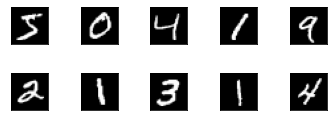

In [351]:
# b = np.zeros_like(subtract_matrix[1])
subtract_matrix_df['euclidean_dist'] = 0 
for i,val in enumerate(subtract_matrix):
    euclidean_dist = np.linalg.norm(val)
    subtract_matrix_df.iloc[i,-1] = euclidean_dist
    
subtract_matrix_df['label'] = y 
top_10=list(subtract_matrix_df.sort_values(by = 'euclidean_dist', ascending=False).index[:10])

rows = 2
cols = 5
axes=[]
fig=plt.figure(figsize = (cols,rows))

for i in range(rows*cols):
    ax = fig.add_subplot(rows, cols, i+1)
    axes.append(ax)
    plt.imshow(X[i,:].reshape(28,28),cmap='gray')
fig.tight_layout()    
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.show()

The rows with the largest euclidean distance can be considered as anomalous data points as they show the largest deviation from the normal since we use the matrix obtained from subtracting the approximated one from the original one. Therefore, we receive images which could be misclassified into other clusters because they are hard to classify and confuse the algorithm. For instance, the 4th image could be classified as a one or a seven as it's a slanted line. 

## Exercise 2 (35 points)

a) Modify the code below to pick 4 categories of news articles that you think are minimally related (for example `sci.space` and `rec.sport.baseball`). (3 points)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer

categories = ['talk.politics.guns', 'sci.space', 'rec.sport.baseball', 'alt.atheism']# your categories here
news_data = fetch_20newsgroups(subset='train', categories=categories)


b) Using the `SnowballStemmer`, stem the words in every article (10 points)

In [3]:
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

def stemming(text):
    snowball = SnowballStemmer(language='english')
    list=[]
    for token in word_tokenize(text):
        list.append(snowball.stem(token))
    return ' '.join(list)

corpus = []
for article in news_data['data']:
    corpus.append(stemming(article))

In [186]:
# if you get a Lookup error, do the following:
# import nltk
# nltk.download()

c) Use the `TfidfVectorizer` on the stemmed articles. Set `min_df` and `max_df` to reasonable numbers and briefly explain your reasoning. Store the resulting dataset into a `.csv` file. (7 points)

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
vectorizer = TfidfVectorizer(max_df=0.5, min_df = 0.01)
X = vectorizer.fit_transform(corpus)
# vectorizer.get_feature_names_out()

tfidf = X.toarray()
df = pd.DataFrame(tfidf, columns=vectorizer.get_feature_names_out())
# print(df)
df.to_csv("tf_idf.csv")
df

,00,000,01,02,04,05,06,07,08,10,...,yesterday,yet,york,young,your,yourself,yoyo,zero,zoo,zoolog
0,0.134281,0.797097,0.01581,0.0,0.043867,0.0,0.017815,0.0,0.017573,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.01724,0.00000,0.000000
1,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.00000,0.000000
2,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.00000,0.000000
3,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.00000,0.000000
4,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2211,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.00000,0.000000
2212,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.00000,0.000000
2213,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.12632,0.139115
2214,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.00000,0.000000


max_df is used for removing terms that appear too frequently, also known as "corpus-specific stop words". 
max_df = 0.50 means "ignore terms that appear in more than 50% of the documents". 

min_df is used for removing terms that appear too infrequently.
min_df = 0.01 means "ignore terms that appear in less than 1% of the documents".

d) For rank k ranging from 1 to 25:

1. Reduce the dimensionality of the tfidf vectorized data using a dimension reduction technique discussed in class.
2. Apply Kmeans on the reduced dataset to create 4 clusters
3. Record the disagreement distance between the clustering in 2 and the article category

Then plot the recorded disagreement distance per rank. Comment briefly. (15 points)

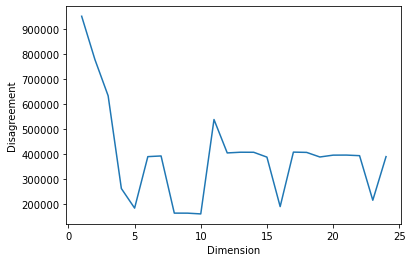

In [208]:
disagreement_distance = []
u,s,vt=np.linalg.svd(tfidf,full_matrices=False)

for k in range(1,25):

    s_copy=s.copy()
    s_copy[k:]=0
    dim_reduced_dataset = u@np.diag(s_copy)@vt

    
    kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=100, n_init=10, random_state=0)
    kmeans.fit_predict(dim_reduced_dataset)
    labelsk = kmeans.labels_
    disagreement_distance.append(disagreement_dist(labelsk, news_data.target))

plt.plot(range(1,25), disagreement_distance)
plt.ylabel('Disagreement')
plt.xlabel('Dimension')
plt.show()

The recorded disagreement distance per rank plot helps to assess the "quality" of different approximations by executing the same clustering on all of them and computing the disagreement with the original labels. Due to the various categories that were chosen, we see differences in the disagreement distance computed for every rank chosen.